In [3]:
from __future__ import print_function
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
from scipy.signal import argrelextrema
import numpy as np
from matplotlib import pyplot as plt

listOfFingerprints = dict()

In [4]:
def makeSongDict(listOfSongs):
    # ==============================================

    time_period = 1 # FFT time period (in seconds). Can comfortably process time frames from 0.05 seconds - 10 seconds

    # ==============================================
    
    for filename in listOfSongs:

        fs_rate, signal_original = wavfile.read(filename)
        total_time = int(np.floor(len(signal_original)/fs_rate))
        sample_range = np.arange(0,total_time,time_period)
        total_samples = len(sample_range)

        #print ("Frequency sampling", fs_rate)
        #print ("total time: ", total_time)
        #print ("sample time period: ", time_period)
        #print ("total samples: ", total_samples)

        output_array = []
        for i in sample_range:

            #print ("Processing: %d / %d (%d%%)" % (i/time_period + 1, total_samples, (i/time_period + 1)*100/total_samples))

            sample_start = int(i*fs_rate)
            sample_end = int((i+time_period)*fs_rate)
            signal = signal_original[sample_start:sample_end]


            l_audio = len(signal.shape)
            #print ("Channels", l_audio)

            if l_audio == 2:
                signal = signal.sum(axis=1) / 2
            N = signal.shape[0]
            #print ("Complete Samplings N", N)

            secs = N / float(fs_rate)
            # print ("secs", secs)
            Ts = 1.0/fs_rate # sampling interval in time
            #print ("Timestep between samples Ts", Ts)

            t = scipy.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray

            FFT = abs(scipy.fft.fft(signal))
            FFT_side = FFT[range(int(N/2))] # one side FFT range
            freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
            fft_freqs = np.array(freqs)
            freqs_side = freqs[range(int(N/2))] # one side frequency range
            fft_freqs_side = np.array(freqs_side)

            # Reduce to 0-5000 Hz
            bucket_size = 20
            buckets = 16

            FFT_side = FFT_side[0:bucket_size*buckets]
            fft_freqs_side = fft_freqs_side[0:bucket_size*buckets]

            # Combine frequencies into buckets
            FFT_side = np.array([int(sum(FFT_side[current: current+bucket_size])) for current in range(0, len(FFT_side), bucket_size)])
            fft_freqs_side = np.array([int(sum(fft_freqs_side[current: current+bucket_size])) for current in range(0, len(fft_freqs_side), bucket_size)])

            # FFT_side: Normalize (0-1)
            max_value = max(FFT_side)
            if (max_value != 0):
                FFT_side_norm = FFT_side / max_value

            # Append to output array
            output_array.append(FFT_side_norm)

        fingerprint = abs(FFT_side_norm)
        
        listOfFingerprints[filename] = fingerprint
        
    
# ============================================



In [5]:
songs = ["tyler.wav", "silversurfer.wav"]
makeSongDict(songs)

/tmp/ipykernel_149/224038243.py:43: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  t = scipy.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray
/tmp/ipykernel_149/224038243.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_rate, signal_original = wavfile.read(filename)


In [6]:
print(listOfFingerprints)

{'tyler.wav': array([0.14112344, 0.06952711, 0.08910117, 0.16654644, 0.33784761,
       0.24616993, 0.92745424, 0.48507347, 0.33984693, 0.43485961,
       0.44726484, 0.37013433, 0.57663084, 1.        , 0.84133715,
       0.44747777]), 'silversurfer.wav': array([0.01915879, 0.02890055, 0.06931221, 0.14088916, 0.23894789,
       0.65926529, 0.48677785, 0.91207645, 0.68130914, 0.62856001,
       0.52670241, 0.69394637, 0.75728238, 1.        , 0.70828008,
       0.96012748])}


In [36]:
import copy

def compare(testList,dictionary):
    #create a list of scores the same length of lists
    scores = []
    
    songLists=list(dictionary.values())
    songNameList = list(dictionary)
    print(songLists)
    print(scores)
    
    for songFFT in songLists:
        
        scores.append(np.allclose(songFFT, testList, .0005, .00005))
    
    songIndex = scores.index(True)
    songKey = songNameList[songIndex]
        
    
    
    print(songKey)

In [37]:
testList = [0.14112344, 0.06952711, 0.08910117, 0.16654644, 0.33784761,
       0.24616993, 0.92745424, 0.48507347, 0.33984693, 0.43485961,
       0.44726484, 0.37013433, 0.57663084, 1.        , 0.84133715,
       0.44747777]

compare(testList, listOfFingerprints)

[array([0.14112344, 0.06952711, 0.08910117, 0.16654644, 0.33784761,
       0.24616993, 0.92745424, 0.48507347, 0.33984693, 0.43485961,
       0.44726484, 0.37013433, 0.57663084, 1.        , 0.84133715,
       0.44747777]), array([0.01915879, 0.02890055, 0.06931221, 0.14088916, 0.23894789,
       0.65926529, 0.48677785, 0.91207645, 0.68130914, 0.62856001,
       0.52670241, 0.69394637, 0.75728238, 1.        , 0.70828008,
       0.96012748])]
[]
tyler.wav


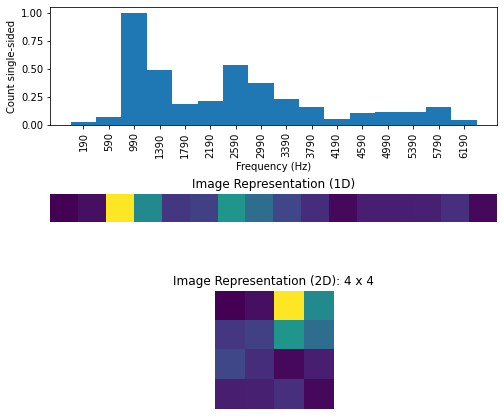

In [2]:
# Plotting


plt.figure(figsize=(8,10))

plt.subplot(412)
diff = np.diff(fft_freqs_side)
widths = np.hstack([diff, diff[-1]])
plt.bar(fft_freqs_side, abs(FFT_side_norm), width=widths) # plotting the positive fft spectrum
plt.xticks(fft_freqs_side, fft_freqs_side, rotation='vertical')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count single-sided')

FFT_side_norm_line = FFT_side_norm.copy()
FFT_side_norm_line.resize( (1,buckets) )

plt.subplot(413)
plt.imshow(FFT_side_norm_line)
plt.axis('off')
plt.title('Image Representation (1D)')

width_img = int(np.sqrt(buckets))
height_img = int(np.ceil(buckets / int(np.sqrt(buckets))))
FFT_side_norm_rect = FFT_side_norm.copy()
FFT_side_norm_rect.resize( (width_img,height_img) )

plt.subplot(414)
plt.imshow(FFT_side_norm_rect)
plt.axis('off')
plt.title('Image Representation (2D): %d x %d' % (width_img,height_img))

plt.show()